<a href="https://colab.research.google.com/github/Ricardomanuel1/Maestria_Ciencia_de_Datos/blob/main/MACHINE%20LEARNING%20Y%20DEEP%20LEARNING/5_BatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Batch Normalization**

Si se usa la inicialización de He junto con ReLU (o cualquiera de sus variantes) se reduce significativamente el peligro de que los gradientes desaparezcan o exploten al inicio del entrenamiento, aunque esto no garantiza que vayan a ocurrir durante el entrenamiento. *Batch Normalization* previene esto.
- En 2015, Ioffe y Szegedy propusieron una técnica llamada normalización por lotes, *Batch Normalization* (BN) que aborda estos problemas.

- La técnica consiste en agregar una operación en el modelo justo antes o después de la función de activación de cada capa oculta.

- Esta operación simplemente centra en cero y normaliza cada entrada, luego escala y desplaza el resultado usando dos nuevos vectores de parámetros por capa: uno para escalar y el otro para desplazar.

- En otras palabras, la operación permite que el modelo aprenda la escala óptima y media de cada una de las entradas de la capa. En muchos casos, si se agrega una capa BN como la primera capa de la red neuronal, no se necesita estandarizar el conjunto de entrenamiento. Es decir, no hay necesidad de StandardScaler o Normalization;  BN lo hará por nosotros.

- Para centrar en cero y normalizar las entradas, el algoritmo necesita estimar la media y la desviación estándar de cada entrada. Lo hace evaluando la media y la desviación estándar de la entrada sobre el mini batch actual (de ahí el nombre "batch normalization"). Toda la operación se resume a la Ecuación siguiente.

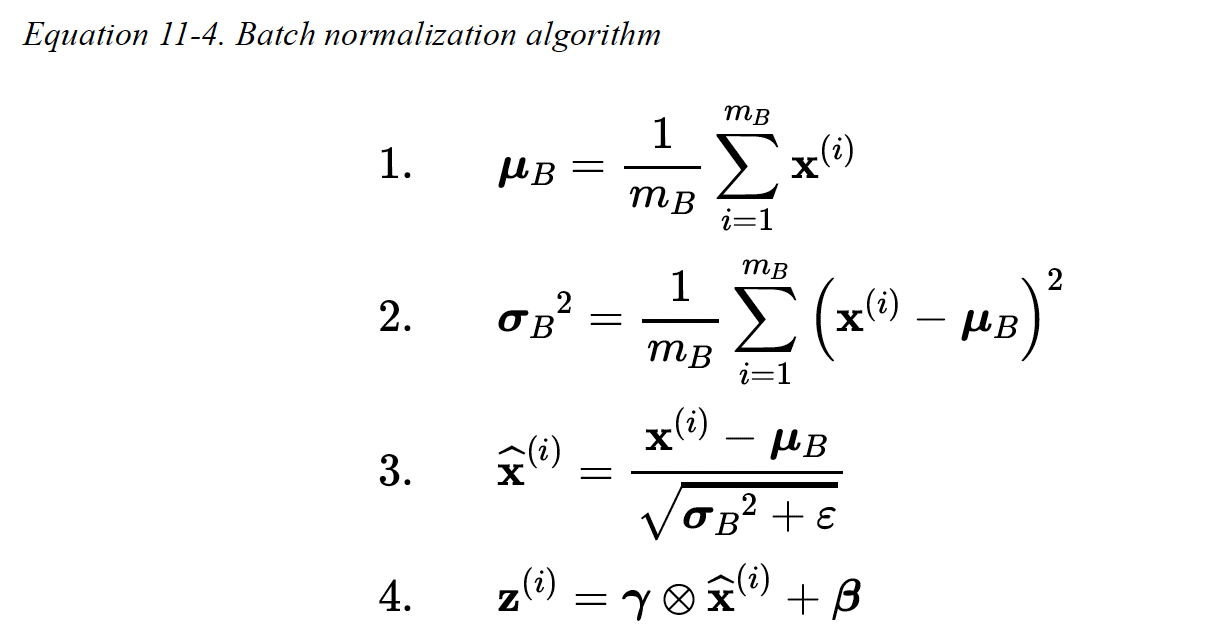


En este algoritmo:
- $\boldsymbol{\mu}_{B}$ es el vector de medias de la entrada, evaluado en todo el mini batch $B$
(contiene un promedio por cada variable de entrada).
- $m_B$ es el número de instancias en el mini batch B.
- $\boldsymbol{\sigma}_B$ es el vector de desviaciones estándar de la entrada, también evaluado sobre el mini batch completo (contiene una desviación estándar por entrada).
- $\skew{4.5}\hat{\mathbf{x}}^{(i)}$ es el vector de entradas normalizadas y centradas en cero, para el ejemplo i.
- $ɛ$ es un número pequeño que evita la división por cero y asegura que los gradientes no crezcan demasiado (normalmente $10^{-5}$). Se denomina *smoothing term*.
- γ es el vector de parámetros de escala de salida para la capa (contiene un
parámetro de escala por cada entrada).
- ⊗ representa la multiplicación por cada punto (cada entrada se multiplica por su correspondiente parámetro de escala de salida).
- $\boldsymbol{\beta}$ es el vector de parámetros de desplazamiento (offset) de salida para la capa (contiene
un parámetro de offset por cada entrada).

- $\mathbf{z}^{(i)}$ es la salida de la operación BN. Es una version de las entradas reescalada y desplazada.




En resumen:
- Cuatro vectores de parámetros son aprendidos en cada capa de Batch normalizations: γ (el vector de escala de salida) y β (el vector de desplazamiento de salida) se aprenden mediante backpropagation, $\boldsymbol{\mu}$ (el vector medio de las entradas final) y $\boldsymbol{\sigma}$ (la desviación estándar de entradas final) se estiman utilizando una media móvil exponencial.

- Tenga en cuenta que $\boldsymbol{\mu}$ y $\boldsymbol{\sigma}$ se estiman durante el entrenamiento, pero se utilizan sólo después de este proceso(para reemplazar las medias y desviaciones estándares en los bactches). El objetivo es que puedan ser usadas en el conjunto de prueba y también en la predicción de nuevas instancias.


Ioffe y Szegedy demostraron que batch normalization mejoró considerablemente todas las redes neuronales profundas con las que experimentaron. Esto llevó a un gran mejora en la tarea de clasificación de ImageNet. El problema de las vanishing gradients fue fuertemente reducido, hasta el punto de que podrían utilizar funciones de activación saturantes como la función de activación tanh e incluso sigmoidea. Las redes fueron mucho menos sensibles a la inicialización de los pesos. Los autores pudieron utilizar tasas de aprendizaje mucho mayores, acelerando significativamente el proceso de aprendizaje.

En resumen indicaron:

*Applied to a state-of-the-art image classification model, batch normalization achieves the same accuracy with 14 times fewer training
steps, and beats the original model by a significant margin. […] Using
an ensemble of batch-normalized networks, we improve upon the best
published result on ImageNet classification: reaching 4.9% top-5
validation error (and 4.8% test error), exceeding the accuracy of human
raters*.

Finalmente:
-  Batch normalization actúa como un
regularizador, lo que reduce la necesidad de otras técnicas de regularización. Sin embargo, BN añade cierta complejidad al modelo.
- Existe una penalización en el tiempo de ejecución: la red neuronal hace predicciones más lentas debido a los cálculos adicionales requeridos en cada capa.
- Afortunadamente, es posible fusionar la capa BN con la capa anterior después del entrenamiento, evitando así la penalización de tiempo de ejecución

In [1]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Datos: Fashion MNIST

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4422102/4422102 [==============================] - 0s 0us/step


##**Implementación de Batch Normalization con Keras**

- Simplemente agregue una capa de BatchNormalization
antes o después de la función de activación de cada capa oculta. También se puede añadir al inicio.
- Por ejemplo, este modelo aplica BN después de cada capa oculta y como la primera capa (después de aplanar las imágenes de entrada):

In [3]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
#bath normalizacion tiene mas impacto en modelos profundos

En este pequeño ejemplo con solo dos capas ocultas es poco probable que BN tenga un gran impacto, pero para redes más profundas sí puede hacer una tremenda diferencia.

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [ ]:
#entrenable y no entrenables

- Cada capa BN agrega cuatro parámetros por entrada: γ, β, μ y
σ (por ejemplo, la primera capa BN agrega 3136 parámetros, que es 4 × 784).
- Los dos últimos parámetros, μ y σ, son las medias móviles; ellos no son afectados por backpropagation, por lo que Keras los llama "no entrenables"

- Si se cuenta el número total de parámetros BN: 3136 + 1200 + 400, y se divide entre 2, se obtiene 2368, que es el número total de parámetros no entrenables del modelo.

Se inspeccionamos los parámetros de la primera capa BN,  dos de ellos son entrenables:

In [6]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Entrenamiento

In [7]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))#no se usa escalados

Epoch 1/2
1719/1719 [==============================] - 13s 6ms/step - loss: 0.5563 - accuracy: 0.8058 - val_loss: 0.3981 - val_accuracy: 0.8526
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4084 - accuracy: 0.8537 - val_loss: 0.3577 - val_accuracy: 0.8692


In [ ]:
#Se obtuvo un desempeño un 0.8692

- Los autores de BN argumentan que se deben de agregar las capas de BN antes de las funciones de activación, en lugar de después.
-  Esto es debatible y parece depender de la tarea: se puede experimentar con esto para ver qué opción funciona mejor en el conjunto de datos.
- Para agregar las capas BN antes de la función de activación, debe eliminar las funciones de activación de las capas ocultas y agregarlas como capas separadas después de las capas BN.
- Además, dado que BN incluye un parámetro de desplazamiento por entrada, se puede eliminar el término de bias de la capa anterior pasando ``use_bias=False`` .
- Por último, normalmente se puede eliminar la primera capa BN para evitar intercalar la primera capa oculta entre dos capas BN. El código actualizado:

In [8]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [10]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6136 - accuracy: 0.7954 - val_loss: 0.4246 - val_accuracy: 0.8444
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4275 - accuracy: 0.8509 - val_loss: 0.3742 - val_accuracy: 0.8634


La clase BatchNormalization tiene hiperparámetros que se puede modificar.

- El hiperparámetro *momentum* es utilizado por BN cuando actualiza las medias móviles exponenciales; dado un nuevo valor $\mathbf{v}$ (por ejemplo, un nuevo vector de medias o desviaciones estándar calculadas sobre el batch actual), la capa actualiza el promedio móvil $\skew{4.5}\hat{\mathbf{v}}$ usando la siguiente ecuación:
$\skew{4.5}\hat{\mathbf{v}} \leftarrow \skew{4.5}\hat{\mathbf{v}}  \times momentum + \mathbf{v} \times (1 − momentum)$
- Un buen valor de momentm suele estar cerca de 1; por ejemplo, 0,9, 0,99 o
0,999. Más 9s para conjuntos de datos grandes y batch pequeños.

- Otro hiperparámetro importante es el axis: determina qué eje debería normalizarse. Su valor predeterminado es –1, lo que significa que de forma predeterminada
normalizará el último eje (utilizando las medias y desviaciones estándar calculadas
en los demás ejes).



Batch Normalization se ha convertido en una de las capas más utilizadas en Deep Learning, especialmente en CNNs, donde a menudo se omite en la arquitectura: se asumen que se agrega BN después de cada capa.

##**Gradient Clipping**

- Otra técnica para mitigar el problema de los gradientes que explotan es recortarlos durante backpropagation para que nunca excedan un umbral.
- Esto se denomina Gradient Clipping  y se utiliza generalmente en redes neuronales recurrentes, donde el uso de Batch Normalization se complica
- En Keras, implementar Gradient Clipping es solo una cuestión de configurar el argumento ``clipvalue`` o ``clipnorm`` al crear un optimizador.

Todos los tf.keras.optimizers aceptan argumentos clipnorm o clipvalue:

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)#lo normal es usar
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

Este optimizador recortará cada componente del vector de gradiente a un valor entre –1 y 1. Esto significa que todas las derivadas parciales de la pérdida
(con respecto a todos y cada uno de los parámetros entrenables) se recortarán entre
–1 y 1. El umbral es un hiperparámetro que se puede ajustar. Tenga en cuenta que puede cambiar la orientación del vector de gradiente. Por ejemplo, si el vector de gradiente original es [0.9, 100.0], apunta principalmente en la dirección de el segundo eje; pero una vez que se recortas por valor, se obtiene [0.9, 1.0], que
apunta aproximadamente a la diagonal entre los dos ejes. En la práctica, este enfoque funciona bien.

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

Si desea asegurarse de que Gradient Clipping no
cambie la dirección del vector de gradiente, debe usarse clipnorm.